# Only feature augmentation(contrary to task augmentation)

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.nn.functional as F
from tqdm.auto import tqdm,trange
from pathlib import Path
import pandas as pd
import torch.nn.utils.prune as prune
import numpy as np
import random
import learn2learn as l2l
import pickle
import matplotlib.pyplot as plt

/home/samuel/.conda/envs/meta/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
ways = 5 
shots =5

In [4]:
with open("./data/test.pkl",'rb') as f:
    test_data = pickle.load(f)
with open("./data/train.pkl",'rb') as f:
    train_data = pickle.load(f)
with open("./data/validation.pkl",'rb') as f:
    val_data = pickle.load(f)

In [5]:
train_data['images'].shape

(38400, 3, 84, 84)

In [6]:
class Dataset(Dataset):
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir
        self.data = self.load_data(self.data_dir)
        self.transform = transform
        self.images = np.transpose(self.data['images'],(0,2,3,1))
        self.labels = self.data['labels']
    def load_data(self,data_dir):
        with open(data_dir,'rb') as f:
            data = pickle.load(f)
        return data
    def __len__(self): 
        return len(self.data['images'])
    def __getitem__(self,index):
        img = self.images[index]
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label

## Feature augmentation

In [7]:
train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees = 0, translate=(0.1,0.1))

    ])
val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),#原本是10
        transforms.RandomAffine(degrees = 0, translate=(0.1,0.1))
])

In [8]:
train_dataset = Dataset("./data/train.pkl",train_transform)
val_dataset = Dataset("./data/validation.pkl", val_transform)

In [9]:
train_dataset = l2l.data.MetaDataset(train_dataset)
val_dataset = l2l.data.MetaDataset(val_dataset)

In [10]:
task_transforms = [
    l2l.data.transforms.FusedNWaysKShots(train_dataset, n=ways, k=2*shots),
    l2l.data.transforms.LoadData(train_dataset),
    l2l.data.transforms.RemapLabels(train_dataset),
    l2l.data.transforms.ConsecutiveLabels(train_dataset),
]
train_taskset =  l2l.data.TaskDataset(train_dataset, task_transforms, num_tasks=20000)
task_transforms = [
    l2l.data.transforms.FusedNWaysKShots(val_dataset, n = ways, k=2*shots),
    l2l.data.transforms.LoadData(val_dataset),
    l2l.data.transforms.RemapLabels(val_dataset),
    l2l.data.transforms.ConsecutiveLabels(val_dataset),
]
val_taskset =  l2l.data.TaskDataset(val_dataset, task_transforms, num_tasks=20000)

In [12]:
def adaptation(task, learner, fas,loss_func, device):
    data, labels = task
    data = data.to(device)
    labels = labels.to(device)
    sup_mask = np.array(([False]*5+[True]*5)*5)
    query_mask = ~sup_mask
    sup_data , query_data = data[sup_mask], data[query_mask]
    sup_labels , query_labels = labels[sup_mask], labels[query_mask]
    for step in range(fas): # inner loop
        pred = learner(sup_data)
        train_loss = loss_func(pred, sup_labels)
        learner.adapt(train_loss)
    query_pred = learner(query_data)
    query_loss = loss_func(query_pred,query_labels)
    query_acc = (torch.argmax(query_pred,1)==query_labels).sum()/len(query_labels)
    return query_loss, query_acc

def train(EPOCHS, meta_model, train_taskset, val_taskset, loss_func, opt, device, model_name):
    log_file = f"./log/{model_name}.txt"
    res = {
        "train_acc_list" : [],
        "val_acc_list" : [],
        "train_loss_list" : [],
        "val_loss_list" : [],
    }
    last_val_loss=float("inf")
    for epoch in trange(EPOCHS):
        opt.zero_grad()
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        for _ in range(meta_batch):
            learner = meta_model.clone(first_order = False)
            task = train_taskset.sample() # sample 一組 [50,3,84,84],[50]
            query_loss, query_acc = adaptation(task, learner,fas, loss_func, device)
            query_loss.backward()
            train_loss += query_loss.item()
            train_acc += query_acc.item()
            #validation
            learner = meta_model.clone(first_order = False)
            task = val_taskset.sample() # sample 一組 [50,3,84,84],[50]
            query_loss, query_acc = adaptation(task, learner,fas, loss_func, device)
            val_loss+=query_loss.item()
            val_acc +=query_acc.item()
        res["train_acc_list"].append((train_acc/meta_batch))
        res["val_acc_list"].append((val_acc/meta_batch))
        res["train_loss_list"].append((train_loss/meta_batch))
        res["val_loss_list"].append((val_loss/meta_batch))
        for p in meta_model.parameters():
            p.grad.data.mul_(1.0 / meta_batch)
        opt.step()
        
        # write log file
        out = {
            "Epoch" : epoch,
            "train accuracy" : (train_acc/meta_batch),
            "validation accuracy" : (val_acc/meta_batch),
            "train loss" : (train_loss/meta_batch),
            "validation loss" : (val_loss/meta_batch)
        }
        with open(log_file,"a") as f:
            f.write(str(out) + '\n')
            
        # print log
        if (epoch+1)%100==0:
            print(f"Epoch {epoch+1} | Train loss :{train_loss/meta_batch} | Train accuracy : {train_acc/meta_batch}")
            print(f"Epoch {epoch+1} | Validation loss :{val_loss/meta_batch} | Validation accuracy : {val_acc/meta_batch}")
        # save model
        if (epoch+1)%500==0:
            MODEL_PATH=f"./model/{model_name}"
            Path(MODEL_PATH).mkdir(parents=True, exist_ok=True)
            torch.save(meta_model.state_dict(),Path(MODEL_PATH)/f"model_{epoch+1}.pt")
        # early stop
        n = 750
        if len(res["val_loss_list"])>n:
            if (epoch+1)%n == 0:
                avg_val_loss = sum(res["val_loss_list"][-n:])/n
                print("Average val_loss of last 500 epoch:",avg_val_loss)
                if last_val_loss < avg_val_loss:
                    print("Early stop!!!")
                    return res
                last_val_loss = avg_val_loss
    return res

In [13]:
def test(meta_model, test_data, loss_func, device):
    test_loss = 0
    test_acc = 0
    test_sup_images = test_data['sup_images']
    test_sup_labels = test_data['sup_labels']
    test_qry_images = test_data['qry_images']
    all_pred = []
    for i in trange(len(test_sup_images)):
        learner = meta_model.clone(first_order = False)
        sup_image = torch.tensor(test_sup_images[i]).to(device)
        sup_label = torch.tensor(test_sup_labels[i]).to(device)
        qry_image = torch.tensor(test_qry_images[i]).to(device)
        for step in range(fas): # inner loop
            pred = learner(sup_image)
            train_loss = loss_func(pred, sup_label)
            learner.adapt(train_loss)
        output_pred = torch.argmax(learner(qry_image),1).reshape(-1,1).detach().cpu().numpy()
        all_pred += [item for sublist in output_pred for item in sublist]
    return all_pred

In [14]:
maml_lr = 0.5
lr = 1e-3
EPOCHS = 10000
meta_batch = 32
fas = 1
model = l2l.vision.models.ResNet12(output_size=ways).to(device)
meta_model = l2l.algorithms.MAML(model, lr=maml_lr,first_order=False)
opt = torch.optim.Adam(meta_model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss(reduction='mean')
results  = train(EPOCHS, meta_model, train_taskset, val_taskset, loss_func,opt, device, "resnet_mutiple_aug_new")

  1%|▏                  | 100/10000 [43:07<68:09:23, 24.78s/it]

Epoch 100 | Train loss :1.500065390020609 | Train accuracy : 0.37874999083578587
Epoch 100 | Validation loss :1.5789289362728596 | Validation accuracy : 0.32374999253079295


  2%|▎                | 200/10000 [1:26:23<71:19:00, 26.20s/it]

Epoch 200 | Train loss :1.353980315849185 | Train accuracy : 0.4187499866820872
Epoch 200 | Validation loss :1.4292209446430206 | Validation accuracy : 0.39874998899176717


  3%|▌                | 300/10000 [2:09:36<70:46:34, 26.27s/it]

Epoch 300 | Train loss :1.3175203949213028 | Train accuracy : 0.44374998984858394
Epoch 300 | Validation loss :1.4119466058909893 | Validation accuracy : 0.384999989066273


  4%|▋                | 400/10000 [2:52:52<69:53:23, 26.21s/it]

Epoch 400 | Train loss :1.2373286001384258 | Train accuracy : 0.46874998789280653
Epoch 400 | Validation loss :1.3757462799549103 | Validation accuracy : 0.42374998796731234


  5%|▊                | 500/10000 [3:36:17<69:01:15, 26.16s/it]

Epoch 500 | Train loss :1.183063343167305 | Train accuracy : 0.5062499870546162
Epoch 500 | Validation loss :1.3851880058646202 | Validation accuracy : 0.43874998670071363


  6%|█                | 600/10000 [4:19:41<66:29:44, 25.47s/it]

Epoch 600 | Train loss :1.1740789841860533 | Train accuracy : 0.5212499890476465
Epoch 600 | Validation loss :1.296400062739849 | Validation accuracy : 0.46624998562037945


  7%|█▏               | 700/10000 [5:03:11<67:49:17, 26.25s/it]

Epoch 700 | Train loss :1.1025720546022058 | Train accuracy : 0.5687499851919711
Epoch 700 | Validation loss :1.279136959463358 | Validation accuracy : 0.47749999118968844


  8%|█▎               | 800/10000 [5:45:18<65:07:26, 25.48s/it]

Epoch 800 | Train loss :0.9746499639004469 | Train accuracy : 0.5887499824166298
Epoch 800 | Validation loss :1.266623329371214 | Validation accuracy : 0.4924999875947833


  9%|█▌               | 900/10000 [6:24:44<49:26:35, 19.56s/it]

Epoch 900 | Train loss :0.9332261197268963 | Train accuracy : 0.6199999786913395
Epoch 900 | Validation loss :1.2018614821135998 | Validation accuracy : 0.503749989438802


 10%|█▌              | 1000/10000 [7:01:06<66:13:17, 26.49s/it]

Epoch 1000 | Train loss :1.0356442425400019 | Train accuracy : 0.5749999908730388
Epoch 1000 | Validation loss :1.202426239848137 | Validation accuracy : 0.5012499867007136


 11%|█▊              | 1100/10000 [7:40:01<48:22:45, 19.57s/it]

Epoch 1100 | Train loss :0.9082585405558348 | Train accuracy : 0.652499983087182
Epoch 1100 | Validation loss :1.17015665397048 | Validation accuracy : 0.5274999858811498


 12%|█▉              | 1200/10000 [8:19:10<60:43:02, 24.84s/it]

Epoch 1200 | Train loss :0.9520898824557662 | Train accuracy : 0.6062499838881195
Epoch 1200 | Validation loss :1.0617645550519228 | Validation accuracy : 0.5749999824911356


 13%|██              | 1300/10000 [8:53:31<47:14:23, 19.55s/it]

Epoch 1300 | Train loss :0.8873544661328197 | Train accuracy : 0.6562499888241291
Epoch 1300 | Validation loss :1.0869069378823042 | Validation accuracy : 0.5612499853596091


 14%|██▏             | 1400/10000 [9:26:10<46:43:17, 19.56s/it]

Epoch 1400 | Train loss :0.8877934897318482 | Train accuracy : 0.6499999836087227
Epoch 1400 | Validation loss :1.084379006177187 | Validation accuracy : 0.5499999858438969


 15%|██▍             | 1500/10000 [9:58:50<46:18:51, 19.62s/it]

Epoch 1500 | Train loss :0.844679999165237 | Train accuracy : 0.6662499848753214
Epoch 1500 | Validation loss :1.0494266971945763 | Validation accuracy : 0.5624999860301614
Average val_loss of last 500 epoch: 1.1426582730772594


 16%|██▍            | 1600/10000 [10:31:30<45:41:12, 19.58s/it]

Epoch 1600 | Train loss :0.8428689120337367 | Train accuracy : 0.6737499795854092
Epoch 1600 | Validation loss :0.9648623634129763 | Validation accuracy : 0.6124999830499291


 17%|██▌            | 1700/10000 [11:04:09<45:14:36, 19.62s/it]

Epoch 1700 | Train loss :0.7736469935625792 | Train accuracy : 0.6937499828636646
Epoch 1700 | Validation loss :1.0054597090929747 | Validation accuracy : 0.6112499823793769


 18%|██▋            | 1800/10000 [11:36:48<44:36:15, 19.58s/it]

Epoch 1800 | Train loss :0.747915755957365 | Train accuracy : 0.7037499854341149
Epoch 1800 | Validation loss :1.0369407404214144 | Validation accuracy : 0.5749999843537807


 19%|██▊            | 1900/10000 [12:09:26<43:57:53, 19.54s/it]

Epoch 1900 | Train loss :0.8120107660070062 | Train accuracy : 0.6874999748542905
Epoch 1900 | Validation loss :0.9505914365872741 | Validation accuracy : 0.6187499845400453


 20%|███            | 2000/10000 [12:42:05<43:31:42, 19.59s/it]

Epoch 2000 | Train loss :0.7219991711899638 | Train accuracy : 0.7399999815970659
Epoch 2000 | Validation loss :0.9253875110298395 | Validation accuracy : 0.6699999812990427


 21%|███▏           | 2100/10000 [13:14:43<43:00:46, 19.60s/it]

Epoch 2100 | Train loss :0.6794996950775385 | Train accuracy : 0.7599999764934182
Epoch 2100 | Validation loss :0.9060273068025708 | Validation accuracy : 0.6524999858811498


 22%|███▎           | 2200/10000 [13:47:21<42:28:45, 19.61s/it]

Epoch 2200 | Train loss :0.6521363575011492 | Train accuracy : 0.751249979250133
Epoch 2200 | Validation loss :0.8802715083584189 | Validation accuracy : 0.6524999858811498


 22%|███▍           | 2250/10000 [14:03:39<42:03:57, 19.54s/it]

Average val_loss of last 500 epoch: 0.9855396519682059


 23%|███▍           | 2300/10000 [14:19:57<41:56:05, 19.61s/it]

Epoch 2300 | Train loss :0.7495141671970487 | Train accuracy : 0.6962499804794788
Epoch 2300 | Validation loss :0.9308040924370289 | Validation accuracy : 0.6324999770149589


 24%|███▌           | 2400/10000 [14:52:35<41:19:17, 19.57s/it]

Epoch 2400 | Train loss :0.6081756742205471 | Train accuracy : 0.7587499804794788
Epoch 2400 | Validation loss :0.8770594038069248 | Validation accuracy : 0.6549999779090285


 25%|███▊           | 2500/10000 [15:25:13<40:48:19, 19.59s/it]

Epoch 2500 | Train loss :0.5863789040595293 | Train accuracy : 0.7737499717622995
Epoch 2500 | Validation loss :0.8393103443086147 | Validation accuracy : 0.6737499861046672


 26%|███▉           | 2600/10000 [15:57:53<40:18:25, 19.61s/it]

Epoch 2600 | Train loss :0.6151372483000159 | Train accuracy : 0.7649999763816595
Epoch 2600 | Validation loss :0.8871022881940007 | Validation accuracy : 0.6549999797716737


 27%|████           | 2700/10000 [16:30:32<39:42:05, 19.58s/it]

Epoch 2700 | Train loss :0.5955577366985381 | Train accuracy : 0.7462499793618917
Epoch 2700 | Validation loss :0.9032243471592665 | Validation accuracy : 0.6274999855086207


 28%|████▏          | 2800/10000 [17:03:11<39:06:56, 19.56s/it]

Epoch 2800 | Train loss :0.5926844992209226 | Train accuracy : 0.7774999793618917
Epoch 2800 | Validation loss :0.8711621314287186 | Validation accuracy : 0.6599999833852053


 29%|████▎          | 2900/10000 [17:35:52<38:33:51, 19.55s/it]

Epoch 2900 | Train loss :0.5616662837564945 | Train accuracy : 0.7874999735504389
Epoch 2900 | Validation loss :0.8519609048962593 | Validation accuracy : 0.6749999839812517


 30%|████▌          | 3000/10000 [18:08:17<37:52:43, 19.48s/it]

Epoch 3000 | Train loss :0.5695030083879828 | Train accuracy : 0.7849999722093344
Epoch 3000 | Validation loss :0.8790794759988785 | Validation accuracy : 0.6499999826774001
Average val_loss of last 500 epoch: 0.8916207860329499


 31%|████▋          | 3100/10000 [18:40:43<37:24:58, 19.52s/it]

Epoch 3100 | Train loss :0.5093899995554239 | Train accuracy : 0.8174999766051769
Epoch 3100 | Validation loss :0.843432386405766 | Validation accuracy : 0.6712499847635627


 32%|████▊          | 3200/10000 [19:13:07<36:38:25, 19.40s/it]

Epoch 3200 | Train loss :0.5577705246396363 | Train accuracy : 0.7887499779462814
Epoch 3200 | Validation loss :0.8860671631991863 | Validation accuracy : 0.6549999788403511


 33%|████▉          | 3300/10000 [19:45:30<36:07:39, 19.41s/it]

Epoch 3300 | Train loss :0.45700657926499844 | Train accuracy : 0.8249999769032001
Epoch 3300 | Validation loss :0.7636262960731983 | Validation accuracy : 0.6862499825656414


 34%|█████          | 3400/10000 [20:16:57<21:38:59, 11.81s/it]

Epoch 3400 | Train loss :0.5327392630279064 | Train accuracy : 0.7999999765306711
Epoch 3400 | Validation loss :0.8515832982957363 | Validation accuracy : 0.6824999842792749


 35%|█████▎         | 3500/10000 [20:34:56<19:29:12, 10.79s/it]

Epoch 3500 | Train loss :0.4393782797269523 | Train accuracy : 0.8324999772012234
Epoch 3500 | Validation loss :0.7690416751429439 | Validation accuracy : 0.7037499807775021


 36%|█████▍         | 3600/10000 [20:52:54<19:10:21, 10.78s/it]

Epoch 3600 | Train loss :0.5218995015602559 | Train accuracy : 0.7974999770522118
Epoch 3600 | Validation loss :0.8224171465262771 | Validation accuracy : 0.6799999848008156


 37%|█████▌         | 3700/10000 [21:10:53<18:52:08, 10.78s/it]

Epoch 3700 | Train loss :0.4441017664503306 | Train accuracy : 0.8349999748170376
Epoch 3700 | Validation loss :0.8592114662751555 | Validation accuracy : 0.6587499808520079


 38%|█████▋         | 3750/10000 [21:19:52<18:43:09, 10.78s/it]

Average val_loss of last 500 epoch: 0.8373746519597868


 38%|█████▋         | 3800/10000 [21:28:51<18:34:10, 10.78s/it]

Epoch 3800 | Train loss :0.4631452534813434 | Train accuracy : 0.8237499743700027
Epoch 3800 | Validation loss :0.821995991282165 | Validation accuracy : 0.6774999834597111


 39%|█████▊         | 3900/10000 [21:46:49<18:16:17, 10.78s/it]

Epoch 3900 | Train loss :0.44576878286898136 | Train accuracy : 0.8312499802559614
Epoch 3900 | Validation loss :0.7753764418885112 | Validation accuracy : 0.702499981969595


 40%|██████         | 4000/10000 [22:04:48<17:58:46, 10.79s/it]

Epoch 4000 | Train loss :0.41465231962502 | Train accuracy : 0.8374999705702066
Epoch 4000 | Validation loss :0.8681603129953146 | Validation accuracy : 0.6737499823793769


 41%|██████▏        | 4100/10000 [22:22:46<17:39:58, 10.78s/it]

Epoch 4100 | Train loss :0.45728553691878915 | Train accuracy : 0.8312499728053808
Epoch 4100 | Validation loss :0.7976348102092743 | Validation accuracy : 0.6824999814853072


 42%|██████▎        | 4200/10000 [22:40:43<17:22:04, 10.78s/it]

Epoch 4200 | Train loss :0.37089874409139156 | Train accuracy : 0.8599999807775021
Epoch 4200 | Validation loss :0.7007737848907709 | Validation accuracy : 0.7399999778717756


 43%|██████▍        | 4300/10000 [22:58:41<17:04:51, 10.79s/it]

Epoch 4300 | Train loss :0.37892428709892556 | Train accuracy : 0.8537499792873859
Epoch 4300 | Validation loss :0.7682069698348641 | Validation accuracy : 0.6987499818205833


 44%|██████▌        | 4400/10000 [23:16:40<16:45:47, 10.78s/it]

Epoch 4400 | Train loss :0.3744500040775165 | Train accuracy : 0.8649999760091305
Epoch 4400 | Validation loss :0.8000329928472638 | Validation accuracy : 0.6999999741092324


 45%|██████▊        | 4500/10000 [23:34:38<16:28:50, 10.79s/it]

Epoch 4500 | Train loss :0.35556084802374244 | Train accuracy : 0.872499980032444
Epoch 4500 | Validation loss :0.8104968443512917 | Validation accuracy : 0.6837499849498272
Average val_loss of last 500 epoch: 0.8049443749375641


 46%|██████▉        | 4600/10000 [23:52:36<16:10:20, 10.78s/it]

Epoch 4600 | Train loss :0.3597512925043702 | Train accuracy : 0.8774999752640724
Epoch 4600 | Validation loss :0.8205388742499053 | Validation accuracy : 0.6774999862536788


 47%|███████        | 4700/10000 [24:10:33<15:51:51, 10.78s/it]

Epoch 4700 | Train loss :0.38211033772677183 | Train accuracy : 0.849999975413084
Epoch 4700 | Validation loss :0.724729192443192 | Validation accuracy : 0.6949999844655395


 48%|███████▏       | 4800/10000 [24:28:31<15:34:07, 10.78s/it]

Epoch 4800 | Train loss :0.2914297725073993 | Train accuracy : 0.888749971985817
Epoch 4800 | Validation loss :0.7671184930950403 | Validation accuracy : 0.686249976977706


 49%|███████▎       | 4900/10000 [24:46:29<15:16:36, 10.78s/it]

Epoch 4900 | Train loss :0.35583470040000975 | Train accuracy : 0.8649999760091305
Epoch 4900 | Validation loss :0.8118881257250905 | Validation accuracy : 0.6812499854713678


 50%|███████▌       | 5000/10000 [25:04:28<15:00:08, 10.80s/it]

Epoch 5000 | Train loss :0.30338737997226417 | Train accuracy : 0.8899999782443047
Epoch 5000 | Validation loss :0.6839880840852857 | Validation accuracy : 0.7362499833106995


 51%|███████▋       | 5100/10000 [25:22:28<14:41:55, 10.80s/it]

Epoch 5100 | Train loss :0.34024974616477266 | Train accuracy : 0.8699999805539846
Epoch 5100 | Validation loss :0.7684027561917901 | Validation accuracy : 0.7137499777600169


 52%|███████▊       | 5200/10000 [25:40:28<14:24:14, 10.80s/it]

Epoch 5200 | Train loss :0.2532958687952487 | Train accuracy : 0.9074999801814556
Epoch 5200 | Validation loss :0.7677191253751516 | Validation accuracy : 0.6974999886006117


 52%|███████▉       | 5250/10000 [25:49:28<14:15:27, 10.81s/it]

Average val_loss of last 500 epoch: 0.7833811204784239


 53%|███████▉       | 5300/10000 [25:58:28<14:07:24, 10.82s/it]

Epoch 5300 | Train loss :0.29088010254781693 | Train accuracy : 0.9024999793618917
Epoch 5300 | Validation loss :0.7917385241016746 | Validation accuracy : 0.6937499772757292


 54%|████████       | 5400/10000 [26:16:29<13:49:47, 10.82s/it]

Epoch 5400 | Train loss :0.25275600200984627 | Train accuracy : 0.9049999751150608
Epoch 5400 | Validation loss :0.8107742313295603 | Validation accuracy : 0.6787499785423279


 55%|████████▎      | 5500/10000 [26:34:32<13:33:00, 10.84s/it]

Epoch 5500 | Train loss :0.28112413559574634 | Train accuracy : 0.8999999798834324
Epoch 5500 | Validation loss :0.7951680207625031 | Validation accuracy : 0.7112499829381704


 56%|████████▍      | 5600/10000 [26:52:35<13:13:36, 10.82s/it]

Epoch 5600 | Train loss :0.3041185175534338 | Train accuracy : 0.8874999731779099
Epoch 5600 | Validation loss :0.7632996449247003 | Validation accuracy : 0.6887499801814556


 57%|████████▌      | 5700/10000 [27:10:38<12:56:37, 10.84s/it]

Epoch 5700 | Train loss :0.2464072784059681 | Train accuracy : 0.909999979659915
Epoch 5700 | Validation loss :0.8017734885215759 | Validation accuracy : 0.6912499843165278


 58%|████████▋      | 5800/10000 [27:28:42<12:38:38, 10.84s/it]

Epoch 5800 | Train loss :0.2918728212825954 | Train accuracy : 0.886249978095293
Epoch 5800 | Validation loss :0.8240122199058533 | Validation accuracy : 0.7124999836087227


 59%|████████▊      | 5900/10000 [27:46:45<12:20:13, 10.83s/it]

Epoch 5900 | Train loss :0.23225038341479376 | Train accuracy : 0.9187499787658453
Epoch 5900 | Validation loss :0.7539191106334329 | Validation accuracy : 0.7024999838322401


 60%|█████████      | 6000/10000 [28:04:49<12:03:50, 10.86s/it]

Epoch 6000 | Train loss :0.27668157522566617 | Train accuracy : 0.8862499725073576
Epoch 6000 | Validation loss :0.8755541052669287 | Validation accuracy : 0.667499978095293
Average val_loss of last 500 epoch: 0.7778016680773968


 61%|█████████▏     | 6100/10000 [28:22:54<11:45:00, 10.85s/it]

Epoch 6100 | Train loss :0.20220647286623716 | Train accuracy : 0.9324999768286943
Epoch 6100 | Validation loss :0.8422382641583681 | Validation accuracy : 0.6874999795109034


 62%|█████████▎     | 6200/10000 [28:40:59<11:27:07, 10.85s/it]

Epoch 6200 | Train loss :0.24024521664250642 | Train accuracy : 0.9162499792873859
Epoch 6200 | Validation loss :0.7764984457753599 | Validation accuracy : 0.731249975040555


 63%|█████████▍     | 6300/10000 [28:59:03<11:08:52, 10.85s/it]

Epoch 6300 | Train loss :0.22898023069137707 | Train accuracy : 0.9174999762326479
Epoch 6300 | Validation loss :0.7879504999145865 | Validation accuracy : 0.7212499855086207


 64%|█████████▌     | 6400/10000 [29:18:07<10:55:42, 10.93s/it]

Epoch 6400 | Train loss :0.1967955293948762 | Train accuracy : 0.9299999829381704
Epoch 6400 | Validation loss :0.7783888620324433 | Validation accuracy : 0.7112499829381704


 65%|█████████▊     | 6500/10000 [29:47:47<19:01:15, 19.56s/it]

Epoch 6500 | Train loss :0.19625145458849147 | Train accuracy : 0.9249999783933163
Epoch 6500 | Validation loss :0.8562090341001749 | Validation accuracy : 0.6874999832361937


 66%|█████████▉     | 6600/10000 [30:20:23<18:34:25, 19.67s/it]

Epoch 6600 | Train loss :0.2070294285658747 | Train accuracy : 0.9262499753385782
Epoch 6600 | Validation loss :0.8228107783943415 | Validation accuracy : 0.6837499812245369


 67%|██████████     | 6700/10000 [30:53:01<17:59:07, 19.62s/it]

Epoch 6700 | Train loss :0.1676291500334628 | Train accuracy : 0.9499999862164259
Epoch 6700 | Validation loss :0.7673015967011452 | Validation accuracy : 0.7149999793618917


 68%|██████████▏    | 6750/10000 [31:09:21<17:41:49, 19.60s/it]

Average val_loss of last 500 epoch: 0.7746580927815909


 68%|██████████▏    | 6800/10000 [31:25:41<17:27:24, 19.64s/it]

Epoch 6800 | Train loss :0.20599108427995816 | Train accuracy : 0.9287499748170376
Epoch 6800 | Validation loss :0.7868964858353138 | Validation accuracy : 0.7174999760463834


 69%|██████████▎    | 6900/10000 [31:58:21<16:50:00, 19.55s/it]

Epoch 6900 | Train loss :0.2456944371078862 | Train accuracy : 0.8999999798834324
Epoch 6900 | Validation loss :0.8012979039922357 | Validation accuracy : 0.6962499851360917


 70%|██████████▌    | 7000/10000 [32:31:01<16:18:35, 19.57s/it]

Epoch 7000 | Train loss :0.1666904910816811 | Train accuracy : 0.946249982342124
Epoch 7000 | Validation loss :0.7989020012319088 | Validation accuracy : 0.708749976940453


 71%|██████████▋    | 7100/10000 [33:03:42<15:47:59, 19.61s/it]

Epoch 7100 | Train loss :0.1490343147306703 | Train accuracy : 0.9387499839067459
Epoch 7100 | Validation loss :0.7613992327824235 | Validation accuracy : 0.7099999841302633


 72%|██████████▊    | 7200/10000 [33:36:22<15:16:27, 19.64s/it]

Epoch 7200 | Train loss :0.21197787910932675 | Train accuracy : 0.9212499745190144
Epoch 7200 | Validation loss :0.7955943010747433 | Validation accuracy : 0.692499983124435


 73%|██████████▉    | 7300/10000 [34:09:02<14:41:14, 19.58s/it]

Epoch 7300 | Train loss :0.14524597811396234 | Train accuracy : 0.9437499791383743
Epoch 7300 | Validation loss :0.6756333613302559 | Validation accuracy : 0.7424999866634607


 74%|███████████    | 7400/10000 [34:41:43<14:08:49, 19.59s/it]

Epoch 7400 | Train loss :0.190172532456927 | Train accuracy : 0.9299999848008156
Epoch 7400 | Validation loss :0.7811005441471934 | Validation accuracy : 0.6999999806284904


 75%|███████████▏   | 7499/10000 [35:14:23<11:45:10, 16.92s/it]

Epoch 7500 | Train loss :0.2055539771099575 | Train accuracy : 0.9324999861419201
Epoch 7500 | Validation loss :0.8724846113473177 | Validation accuracy : 0.6749999821186066
Average val_loss of last 500 epoch: 0.7851937726765561
Early stop!!!


<Axes: >

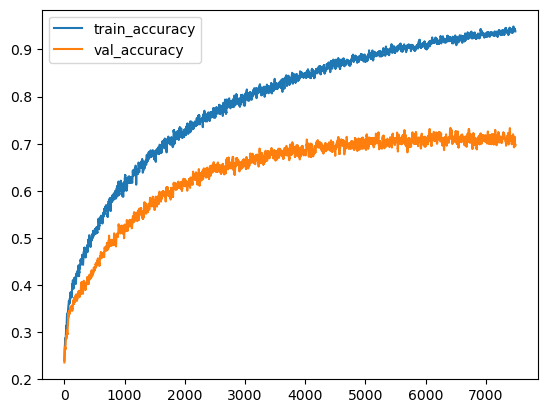

In [21]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
df1 = pd.DataFrame(moving_average(results["train_acc_list"],10),columns=['train_accuracy'])
df2 = pd.DataFrame(moving_average([i for i in results["val_acc_list"]],10),columns=['val_accuracy'])
df = pd.concat([df1,df2],axis=1)
df.plot()

<Axes: >

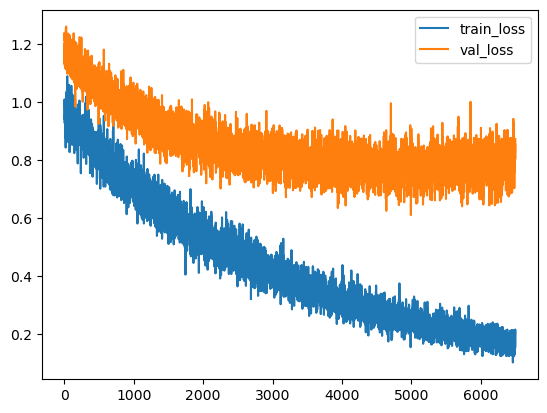

In [18]:
df1 = pd.DataFrame(results["train_loss_list"][1000:],columns=['train_loss'])
df2 = pd.DataFrame([i for i in results["val_loss_list"][1000:]],columns=['val_loss'])
df = pd.concat([df1,df2],axis=1)
df.plot()